# Graph Analysis

This notebook analyzes the recommendation graph

In [1]:
import os
import pandas
import json
import numpy as np
import pandas as pd

import networkx as nx
from matplotlib import pyplot as plt

In [ ]:
# import the graph from adjacency list
G = nx.read_adjlist(create_using=nx.DiGraph(), 
                    path="derived_data/adjacency_list.txt")
#nx.write_graphml(G, 'derived_data/rec_graph.graphml')

# wrap in the features I collected 
with open('scrape_results/video_info.json', 'r') as f:
    video_info = json.load(f)
    

In [19]:
# make a category_name <-> id mapping for easier category handling
category_df = pd.read_csv('derived_data/category_crosswalk.csv')
category_list = category_df.category_id.values

categories = set(category_list)
cat_mapping = {}
for ix, category_id in enumerate(categories):
    cat_mapping[category_id] = ix

In [61]:
# Create node attributes by filling dictionaries with video_id and info
category = {}
views = {}
lr = {}
postdate = {}
channel = {}
for video_id in video_info:
    info = video_info.get(video_id, {})
    try:
        like_ratio = int(info['likes']) / (int(info['likes']) + int(info['dislikes']))
    except ZeroDivisionError:
        like_ratio = 0.5
    
    channel[video_id] = info['channel']
    category[video_id] = cat_mapping[int(info['category'])]
    views[video_id] = int(info['views'])
    lr[video_id] = float(like_ratio)
    postdate[video_id] =  info['postdate']
    
# do the same for channel/video bias
channel_classification = pd.read_csv('derived_data/channel_classification.csv')
video_info_df = pd.DataFrame.from_dict(video_info, orient='index').reset_index()
video_info_df.rename(index=str, columns={"index": "video_id"}, inplace=True)
video_info_df = video_info_df[['video_id', 'channel']]
video_info_df['channel'] = video_info_df.channel.apply(str.lower)
video_info_df = video_info_df.merge(channel_classification, on='channel', how='left')\
                .dropna(axis=0, subset=['leaning'])
bias_dict = video_info_df[['video_id', 'leaning']].set_index('video_id').to_dict(orient='index')

# make dictionary of bias
bias = {}
for video_id in bias_dict:
    bias[video_id] = bias_dict[video_id]['leaning']
    
nx.set_node_attributes(G, name='leaning', values=bias)
nx.set_node_attributes(G, name='category', values=category)
nx.set_node_attributes(G, name='views', values=views)
nx.set_node_attributes(G, name='like_ratio', values=lr)
nx.set_node_attributes(G, name='postdate', values=postdate)
nx.set_node_attributes(G, name='channel', values=channel)

In [65]:
bias

{'--9-_eOeZk8': 'L',
 '--nL5sU8rlQ': 'L',
 '--wsPKKj_H0': 'L',
 '-0fUSvDuttY': 'L',
 '-4OBcRHX1Bc': 'L',
 '-4Y8VF7ZKzY': 'L',
 '-8-RAaXBK60': 'R',
 '-At94Iqg_W4': 'L',
 '-B8MJs2tZe8': 'L',
 '-GwFOWxVr4w': 'L',
 '-JVA8Ng78UU': 'C',
 '-KxGRDep5x0': 'L',
 '-L1EPkYlMj0': 'R',
 '-MUGWmyvZxM': 'L',
 '-MVjP303zP4': 'L',
 '-NYIpYgPqss': 'C',
 '-PxpHNXIKnY': 'R',
 '-QzPBT1Wvl8': 'R',
 '-TFQjYfrE0Q': 'L',
 '-U4Cq-dgNnw': 'C',
 '-Ul3Mjk2YYU': 'L',
 '-W6G_ndFVMY': 'L',
 '-W87eBTh2ZE': 'L',
 '-WLHr1_EVtQ': 'C',
 '-XI4siKp-nU': 'L',
 '-Y7PLaxXUrs': 'C',
 '-YFgydceacM': 'L',
 '-YkLPxQp_y0': 'L',
 '-ZwEVs3HR4Q': 'R',
 '-_M2R64pgJQ': 'L',
 '-avpx8UTakI': 'R',
 '-b2flEOjgjE': 'R',
 '-bF9-Cmri9M': 'L',
 '-dEYmrtBijs': 'R',
 '-dWFKp-bJtk': 'L',
 '-e7jFFN7Q1A': 'R',
 '-etiFoJhmzk': 'L',
 '-f2fvRXWieg': 'L',
 '-ftJ9Q6vsLU': 'L',
 '-hjsuUFujY0': 'L',
 '-iT810q71T0': 'L',
 '-jEZqDQwvp4': 'R',
 '-kjyltrKZSY': 'L',
 '-kkixKBl7OY': 'C',
 '-lgUg0z_wmc': 'R',
 '-mSGwndFMp8': 'L',
 '-nQGBZQrtT0': 'L',
 '-nnXDh2R-uM

In [62]:
# assortativity
print(nx.attribute_assortativity_coefficient(G, 'category'))
print(nx.attribute_assortativity_coefficient(G, 'channel'))
print(nx.attribute_assortativity_coefficient(G, 'leaning'))
#print(nx.numeric_assortativity_coefficient(G, attribute='views'))
#print(nx.numeric_assortativity_coefficient(G, attribute='like_ratio'))

0.5246424047357003
0.40710843585481304
0.6732214376446125


In [77]:
# mix_matrix[i,j] = count of i -> j edges
mix_matrix = nx.attribute_mixing_matrix(G, 
                                        attribute='leaning',
                                        mapping={'L': 0, 'C': 1, 'R': 2},
                                        normalized=False)

# normalize so rows sum to 1; choosing rows so that each cell can
# be interpreted as the frequency with which category i recommends a video
# in category j (row sums are the out-degree)
mix_matrix = mix_matrix / mix_matrix.sum(axis=1, keepdims=True)

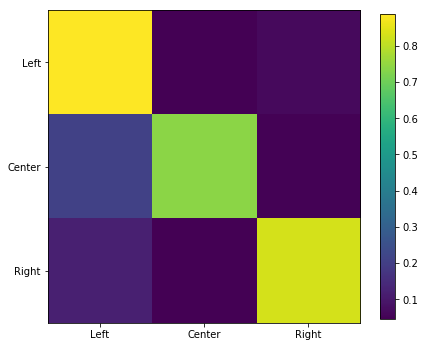

In [85]:
plt.figure(figsize=(7,7))
plt.imshow(mix_matrix)
plt.colorbar(shrink=0.8)
plt.xticks(np.arange(3), ('Left', 'Center', 'Right'))
plt.yticks(np.arange(3), ('Left', 'Center', 'Right'))
plt.savefig('presentation_resources/leaning_mixing_matrix', dpi=300)

In [105]:
# pageranks
pr = nx.pagerank(G)

pr_df = pd.DataFrame.from_dict(pr, orient="index").reset_index()\
                 .rename(index=str, columns={'index': 'video_id', 0: 'pagerank'})
    
pr_df.to_csv('derived_data/pageranks.csv', index=False)